In [1]:
# select the guide stars given a field in DGWF mode

import warnings
warnings.filterwarnings("ignore")

import ceo
import yaml
from yaml import Loader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
sys.path.append(os.path.expanduser('~/PYTHON/ATP/'))
from astropy.units import Quantity
from astropy.time import Time
import astropy.io.fits as pyfits
import atp
import copy
from agwsprobes import *
import scipy.interpolate

/home/ubuntu/CEO/python/ceo/zemax


In [2]:
L=25.5
nPx = 201
nLenslet = 48
threshold = 0.5 # subaperture flux threshold
gmt = ceo.GMT_MX()

In [3]:
def modestogmtstate(gmt,modes):
    state = gmt.state

    M1Txyz = modes[[0,1,2,12,13,14,24,25,26,36,37,38,48,49,50,60,61,62,72,73,74]]
    state['M1']['Txyz'] = np.reshape(M1Txyz,(7,3))

    M2Txyz = modes[[6,7,8,18,19,20,30,31,32,42,43,44,54,55,56,66,67,68,77,78,79]]
    state['M2']['Txyz'] = np.reshape(M2Txyz,(7,3))

    M1Rxyz = np.zeros(21)
    M1Rxyz[0:20] = modes[[3,4,5,15,16,17,27,28,29,39,40,41,51,52,53,63,64,65,75,76]]
    state['M1']['Rxyz'] = np.reshape(M1Rxyz,(7,3))
    
    M2Rxyz = np.zeros(21)
    M2Rxyz[0:20] = modes[[9,10,11,21,22,23,33,34,35,45,46,47,57,58,59,69,70,71,80,81]]
    state['M2']['Rxyz'] = np.reshape(M2Rxyz,(7,3))
    gmt^=state

In [4]:
girmode = "tracking"
config = "dgwf"
maxstarsperprobe = 8 # maximum number of stars per probe to analyze

# this contains information about the observation
cfg = yaml.load(open(os.path.expanduser('~/PYTHON/ATP/atp.yaml')),Loader)

In [5]:
# load the data about the observation
data = pyfits.getdata(os.path.expanduser('~/PYTHON/AGWS/SAO/weather_pointing_data.fits'))
temperature = data[:,0] # Temperature draw in deg C
pressure = data[:,1] # Pressure draw in mbar
humidity = data[:,2] # Relative humidity in %
windspeed = data[:,3] # Wind speed in m/s
winddir = data[:,4] # Wind direction in degrees
datetime = data[:,5] # Date vector (Clay is first 500, Baade is second 500)
scira = data[:,6] # RA vector (degrees; Clay is first 500, Baade is second 500)
scidec = data[:,7] #  Declination vector (degrees; Clay is first 500, Baade is second 500)
telaz = data[:,8] # Azimuth angle of telescope (degrees; Clay is first 500, Baade is second 500)
telel = data[:,9] # Elevation angle of telescope (degrees; Clay is first 500, Baade is second 500)
r0 = data[:,10] # r0 (cm)
L0 = data[:,11] # L0 (m)

validator = agwsinit(config)

# this notebook only looks at the first field.

In [6]:
#the python file loops over all 1000 fields.
fieldno = 0

In [7]:
datetime[0]

2013.3871424086758

In [8]:
telzen = (90-telel[fieldno])*np.pi/180.
airmass = 1./np.cos(telzen)

cfg['Observation']['time'] = Time(datetime[fieldno] , format='decimalyear', scale='utc')
cfg['Target']['ra'] = scira[fieldno]
cfg['Target']['dec'] = scidec[fieldno]

cfg['Target']['pointing alt/az']['alt'][0] = telel[fieldno]
cfg['Target']['pointing alt/az']['az'][0] = telaz[fieldno]

cfg['Atmosphere']['r0'][0] = r0[fieldno]*100.
cfg['Atmosphere']['L0'][0] = L0[fieldno]

obs = atp.Observatory(**cfg['Observatory'],**cfg['Observation'])
target = atp.Target(obs,**cfg['Target'])

In [9]:
fielddir = "~/PYTHON/AGWS/Fields"
starfield = os.path.expanduser(fielddir+f"/field_{fieldno:04d}.csv")

outputfilename = os.path.expanduser('~/')+f'PYTHON/AGWS/Fields/{config}_asterism_{fieldno:04d}.csv'
probefunction = [None,None,None,None]
gsno = [None,None,None,None] # guide star number
vismaggs = [0,0,0,0]
xposgs = [0,0,0,0]
yposgs = [0,0,0,0]

In [10]:
stars  = atp.StarField(obs,target,field=starfield,**cfg['Star Catalog'])

In [11]:
vismag = 0.46*stars.I+0.54*stars.R
# remove stars that have an NaN for magnitude
valid = ~np.isnan(vismag)
validpos = np.where(valid)[0]

xposarcsec = stars.local[0,:]*180./np.pi*3600
yposarcsec = stars.local[1,:]*180./np.pi*3600

In [12]:
print(len(vismag), len(valid))

1887 1887


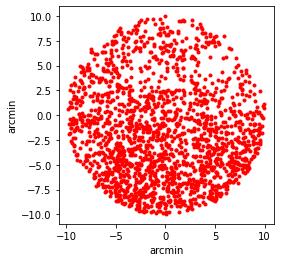

In [13]:
plt.figure(8)
plt.clf()
ax = plt.axes()
ax.set_aspect('equal')
#plt.xlim((-610,610))
#plt.ylim((-610,610))
#plt.plot(xposarcsec[validpos],yposarcsec[validpos],'.',color='red')
plt.plot(xposarcsec[validpos]/60,yposarcsec[validpos]/60,'.',color='red')
plt.xlabel('arcmin')
plt.ylabel('arcmin');

## run agwscheck() to remove invalid stars

In [14]:
gspos = np.transpose(np.array([xposarcsec,yposarcsec]))

nstars = len(xposarcsec)
for k in range(nstars):
    if valid[k]:
        (success,loc,idx) = agwscheck(validator,gspos[[k],:])
        valid[k] = success

In [15]:
validpos = np.where(valid)[0]
print(len(validpos))

1088


In [16]:
if len(validpos) == 0:
    print('There are no guide stars!')
    bestasterism = {'Probe number': [0,1,2,3], 'Probe function': probefunction,'Guide star':gsno,'Visible magnitude':vismaggs,'xpos':xposgs,'ypos':yposgs}

    print(outputfilename)
    df = pd.DataFrame(bestasterism,index=None)
    print (df)
    df.to_csv(outputfilename, index = False, header=True)
    print('PROCEED TO THE NEXT FIELD, SKIP BELOW')

vismag = vismag[validpos]
xposarcsec = xposarcsec[validpos]
yposarcsec = yposarcsec[validpos]

Text(0, 0.5, 'Y-position (arcsec)')

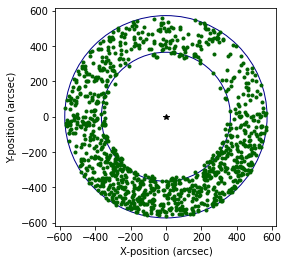

In [17]:
if config == "dgwf":
    minradarcsec = 365 # trial and error
    maxradarcsec = 572.4 # trial and error
if config == "dgnf":
    # the AGWS must be > 6' away to avoid vignetting the field
    minradarcsec = 364.7 
    maxradarcsec = 600
if config == "m3":
    # radius of guide star must be greater than 357.9 mm
    minradarcsec = 365.07
    maxradarcsec = 600

ax = plt.axes()
ax.set_aspect('equal')
plt.plot(xposarcsec,yposarcsec,'.',color='darkgreen')
innercircle = plt.Circle([0,0],radius=minradarcsec,color='darkblue',fill=False)
ax.add_artist(innercircle)
outercircle = plt.Circle([0,0],radius=maxradarcsec,color='darkblue',fill=False)
ax.add_artist(outercircle)
plt.plot([0],[0],'*',color='black')

plt.xlabel('X-position (arcsec)')
plt.ylabel('Y-position (arcsec)')

In [18]:
gspos = np.transpose(np.array([xposarcsec,yposarcsec]))
nvalidstars = len(xposarcsec)   

# determine which probes reach which stars
print('Finding which probes reach which stars')
probesreachstars = agwsreachstars(validator,gspos)

Finding which probes reach which stars


In [19]:
probesreachstars.shape

(4, 1088)

In [20]:
print(probesreachstars)

[[ True  True False ... False False False]
 [False False False ...  True  True False]
 [False False False ...  True  True  True]
 [False False  True ... False False  True]]


In [21]:
# calculate the seeing 
gs_wavelength = Quantity(*cfg['SH']['guide star']['wavelength']).to('m').value
r0_wavelength = Quantity(*cfg['Atmosphere']['wavelength']).to('m').value
r0_val = Quantity(*cfg['Atmosphere']['r0']).to('m').value
r0_val *= atp.r0_scaling(r0_wavelength,gs_wavelength,telzen)
seeingRad = gs_wavelength/r0_val
seeingArcsec = seeingRad*ceo.constants.RAD2ARCSEC
print("seeing (arcsec) : %5.3f" %seeingArcsec)
print("elevation (degrees) : %4.1f" %telel[fieldno])

seeing (arcsec) : 0.757
elevation (degrees) : 68.6


### Before we apply the TT7 criteria, we make sure the total shadow fraction for 4 probes are <0.15. 

This step is only for dgwf, not dgnf

### we next determine the best TT7 star, i.e., which star will be measured with the TT7 probe

we do this by predicting the TT7 error for each star

This error has two parts, the noise_rms and aniso_rms.

The way this is done here is a little different from dgnfguidestars.py. For dgnf, atp.tt7_tt_error is called N times, where N is the number of stars. Here we do it 102 times, for 1,2,3,...,102 arcmin distance to the field center. We then interpolate to N values of radialdistArcmin.

but why this difference? is the interpolation supposed to be a way to save computation time? No, Marcos says it doesn't matter.

In [22]:
# calculate the TT7 error
# find the TT7 error for all stars
print('Calculating TT7 error')
dist = np.arange(1,102)/10.
tt7_aniso_dist = [atp.tt7_tt_error(zz,0.,telzen,**cfg) for zz,magnitude in zip(dist,dist*0.)]
aniso_interp_function = scipy.interpolate.interp1d(dist,tt7_aniso_dist,bounds_error=False)

radialdistArcmin = np.hypot(xposarcsec,yposarcsec)/60.
tt7_aniso_rms = aniso_interp_function(radialdistArcmin)

Calculating TT7 error


In [23]:
# saturation is attained for magnitude 10 stars
# values calculated using tt7noise.i for 0.8" seeing
magvec = np.array([0,10,10.5,11,11.5,12,12.5,13,13.5,14,14.5,15,15.5,16,16.5,17,17.5,18,20])
# this is the error in the segment tip-tilt estimate using a 24x24 SH WFS
tterr_for_800mas = np.array([0.00204073,0.00204073,0.00248421,0.00313843,0.00404597,0.0052902,0.00649479,0.00812451,0.0108732,0.0140705,0.018404,0.0248977,0.0369819,0.0556996,0.0910204,0.13293,0.179323,0.205629,0.205629])*1000.
tterr_mas = tterr_for_800mas*seeingArcsec/0.8

interp_function = scipy.interpolate.interp1d(magvec,tterr_mas,bounds_error=False)
tt7_noise_rms = interp_function(np.clip(vismag,np.min(magvec),np.max(magvec)))
tt7_res_rms = tt7_noise_rms + tt7_aniso_rms

In [24]:
print(len(tt7_res_rms))

1088


In [25]:
# calculate the obscuration by each probe for each star
startloc = np.array([[0,0.159],[-0.159,0],[0,-0.159],[0.159,0]])*3600.
(success,loc,idx) = agwscheck(validator,startloc)
minshadow = validator.shadowfrac

In [26]:
startloc

array([[   0. ,  572.4],
       [-572.4,    0. ],
       [   0. , -572.4],
       [ 572.4,    0. ]])

In [27]:
minshadow

0.094

In [28]:
success

True

In [29]:
loc

array([[   0. ,  572.4],
       [-572.4,    0. ],
       [   0. , -572.4],
       [ 572.4,    0. ]])

In [30]:
idx

array([0, 1, 2, 3])

In [31]:
gspos.shape

(1088, 2)

In [32]:
shadowfraction = np.zeros(probesreachstars.shape)
for k1 in range(4):
    for k2 in range(nvalidstars):
        if probesreachstars[k1,k2]:
            pos = startloc.copy()
            pos[k1,:] = gspos[k2,:]
            (success,loc,idx) = agwscheck(validator,pos)
            shadowfraction[k1,k2] = validator.shadowfrac - 0.75*minshadow

probes_with_stars = probesreachstars.any(axis=1) 
n_probes_with_stars = np.sum(probes_with_stars)

In [33]:
validator.shadowfrac

0.114

In [34]:
shadowfraction

array([[0.0635, 0.0635, 0.    , ..., 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    , ..., 0.0365, 0.0325, 0.    ],
       [0.    , 0.    , 0.    , ..., 0.0255, 0.0255, 0.0245],
       [0.    , 0.    , 0.0645, ..., 0.    , 0.    , 0.0435]])

In [35]:
np.min(shadowfraction) 
#0.75 above is a magic number that makes the min to be zero.
# so the minshadow we determined earlier was 4/3 (=1/0.75) times the actual minshadow

0.0

In [36]:
print(n_probes_with_stars)

4


In [37]:
print('Finding four suitable stars')

# find the valid 4 star asterisms that meet the shadowing requirement
s0 = np.where(probesreachstars[0,:])[0]
s1 = np.where(probesreachstars[1,:])[0]
s2 = np.where(probesreachstars[2,:])[0]
s3 = np.where(probesreachstars[3,:])[0]

Finding four suitable stars


In [39]:
print(s0.shape, s1.shape, s2.shape, s3.shape)

(235,) (418,) (572,) (349,)


In [40]:
# limit the calculation to the brightest 30 stars for each probe
s0 = s0[np.argsort(vismag[s0])][0:30]
s1 = s1[np.argsort(vismag[s1])][0:30]
s2 = s2[np.argsort(vismag[s2])][0:30]
s3 = s3[np.argsort(vismag[s3])][0:30]   

In [41]:
print(s0,s1,s2,s3)

[ 895  444  594  341  814  348   66  584  486  310  131  969  935  647
  312  568  687 1051  213  612  815  759  784  944  783  143  436  824
 1006  453] [ 657  895  832  444  594  341  541  152  256  982  584  486  785  753
  844  378  205  782 1051  727   44  693  815 1069  237  759  342  928
  195  944] [ 268  856  109  541  281  442  982  726  900  964  816  652  717  231
  499  216  782  897  492  309  727  693 1069   99 1005  390  928  858
  195  382] [ 918   89  268  814  281   58   74  345  935  726 1060  190  816  652
  499  324  637  309  322 1005  784  382  448  783 1011  824  470  894
  841  383]


In [42]:
pos = np.zeros((4,2))
validasterisms = []

In [43]:
# keep track of the shadowing and report it        
for m0 in s0.tolist():
    frac0 = shadowfraction[0,m0]
    pos[0,:] = gspos[m0,:]

    for m1 in s1.tolist():
        if m1 == m0:
            continue
        pos[1,:] = gspos[m1,:]

        frac1 = shadowfraction[1,m1]
        for m2 in s2.tolist():
            if m2 == m1 or m2 == m0:
                continue
            frac2 = shadowfraction[2,m2]
            pos[2,:] = gspos[m2,:]

            for m3 in s3.tolist():
                if m3 == m2 or m3 == m1 or m3 == m0:
                    continue
                frac3 = shadowfraction[3,m3]
                pos[3,:] = gspos[m3,:]

                frac = frac0+frac1+frac2+frac3 
                if frac <= 0.15:
                    # check if asterism is valid
                    (success,loc,idx) = agwscheck(validator,pos)
                    if success:
                        validasterisms.append([m0,m1,m2,m3])

In [44]:
nAsterism = len(validasterisms)
print(nAsterism)

34861


In [45]:
# select the 25 asterisms with the brightest faint star
maxasterisms = 25
maxmag = np.zeros(nAsterism)
counter = 0
for k,asterism in enumerate(validasterisms):
    maxmag[k] = np.max(vismag[asterism]) #largest mag = faint star in each asterism

In [46]:
print(maxmag)

[10.70908444 11.50795519 12.76456603 ... 13.79180246 13.82113166
 13.83032053]


In [47]:
sortmag = np.argsort(maxmag)
brightasterisms = np.array(validasterisms)[sortmag][0:np.clip(nAsterism,0,maxasterisms)]

In [48]:
np.clip(nAsterism,0,maxasterisms)

25

In [49]:
# find the best TT7 star in those bright asterisms
brightstars = np.sort(np.array(list(set(np.ndarray.flatten(brightasterisms)))))

In [50]:
brightasterisms

array([[895, 657, 856, 918],
       [895, 832, 856, 918],
       [594, 895, 856, 918],
       [594, 832, 856, 918],
       [594, 657, 856, 918],
       [895, 832, 856, 814],
       [895, 657, 856, 814],
       [594, 895, 856, 814],
       [594, 657, 856, 814],
       [594, 832, 856, 814],
       [348, 832, 856, 814],
       [348, 832, 856, 918],
       [348, 895, 856, 814],
       [348, 895, 856, 918],
       [348, 657, 856, 918],
       [348, 657, 856, 814],
       [814, 832, 982, 918],
       [895, 832, 982, 814],
       [348, 657, 982, 918],
       [348, 895, 982, 918],
       [348, 895, 982, 814],
       [348, 832, 982, 814],
       [348, 657, 982, 814],
       [348, 832, 982, 918],
       [594, 982, 856, 918]])

In [51]:
brightstars

array([348, 594, 657, 814, 832, 856, 895, 918, 982])

#### for now we use the best TT7 star

In [52]:
# sort from lowest to highest error
tt7_gs_indices = np.argsort(tt7_res_rms[brightstars])
tt7idx = brightstars[tt7_gs_indices[0]]

In [53]:
tt7idx

657

In [54]:
# find the asterisms that include the brightest TT7 star
selectedasterisms = [] 
for asterism in brightasterisms:
    if tt7idx in asterism:
        selectedasterisms.append(asterism)

In [55]:
selectedasterisms

[array([895, 657, 856, 918]),
 array([594, 657, 856, 918]),
 array([895, 657, 856, 814]),
 array([594, 657, 856, 814]),
 array([348, 657, 856, 918]),
 array([348, 657, 856, 814]),
 array([348, 657, 982, 918]),
 array([348, 657, 982, 814])]

#### supposed to loop over all the asterisms. We step through the first, then loop over all of them

In [56]:
# find the best performing active optics asterism
nAsterism = len(selectedasterisms)
res = np.zeros(nAsterism)
ast = 0
asterism = selectedasterisms[0]

In [57]:
gsidx = asterism.tolist()
gsidx.remove(tt7idx)
gsidx = np.array(gsidx)

In [58]:
gsidx

array([895, 856, 918])

In [59]:
# generate a reconstructor for each one for one segment
wfs = ceo.GeometricShackHartmann(nLenslet,L/nLenslet,3,coupled=True)
print(nLenslet, L)

48 25.5


In [60]:
pos = gspos[gsidx,:]
zen = [np.hypot(pos[i,0],pos[i,1])/206265. for i in range(3)]
azi = [np.arctan2(pos[i,0],pos[i,1]) for i in range(3)]
mag = vismag[gsidx]

In [61]:
pos

array([[-460.04640211,  287.18380339],
       [ -39.53599425, -532.95225354],
       [ 537.97701087,  -91.4335867 ]])

In [62]:
mag

array([10.65870517, 10.70908444,  9.18692908])

In [63]:
gs = ceo.Source(photometric_band="R+I",zenith=zen,azimuth=azi,magnitude=np.array([10,10,10]),
                rays_box_size=L,rays_box_sampling=nLenslet*8+1,rays_origin=[0,0,25])

# run my own calibration, because the interaction matrix is not consistent with the measured values
gs.reset()
gmt.reset()
gmt.propagate(gs)
wfs.calibrate(gs,threshold)
gs>>(gmt,wfs)
nmes = len(wfs.get_measurement())
nvl = np.sum(wfs.valid_lenslet.f.host(shape=(3,48**2))>0,axis=1)

In [64]:
print(threshold, nmes, nvl)

0.5 7238 [1200 1212 1207]


In [65]:
magvec = np.array([0,13,13.5,14,14.5,15,15.5,16,16.5,17,17.5,18,18.5,19,19.5,20])

# this is the error in the segment tip-tilt estimate using a 24x24 SH WFS
meserr_for_800mas = np.array([0.00136217,0.00136217,0.00171104,0.00216745,0.00275779,0.00351932,0.00453948,0.00590709,0.00780148,0.0104783,0.0144437,0.0204345,0.0296933,0.044133,0.0674427,0.110046]) # measurement error per subaperture
meserr_mas = meserr_for_800mas*seeingArcsec/0.8
sh_interp_function = scipy.interpolate.interp1d(magvec,meserr_mas,bounds_error=False)

noisediag = np.zeros(nmes)
idx0 = 0
n2 = int(nmes/2)
for c1 in range(3):
    sh_noise_rms = sh_interp_function(np.clip(mag[c1],np.min(magvec),np.max(magvec)))
    noisediag[idx0:idx0+nvl[c1]] = sh_noise_rms # noise in arcsec
    noisediag[idx0+n2:idx0+n2+nvl[c1]] = sh_noise_rms # noise in arcsec
    idx0 += nvl[c1]

poke = 5e-6
Rxyz = [3,4,5,9,10,11]# modes are M1S1Rxyz and M2S1Rxyz
nmodes = 82
H = np.zeros((nmes,nmodes))

In [66]:
~gmt
for k in Rxyz:
    modes = np.zeros(nmodes)
    modes[k] = poke
    modestogmtstate(gmt,modes)
    ~wfs
    gs>>(gmt,wfs)
    +gs
    +wfs
    mes = wfs.get_measurement()
    H[:,k] = mes/poke

H = H[:,Rxyz]

In [67]:
#penmat = np.eye(6)*1e-7*0.
#Hinv = np.linalg.solve(np.transpose(H)@H+penmat,np.transpose(H))
Hinv = np.linalg.solve(np.transpose(H)@H,np.transpose(H))
Cnn = np.diag(noisediag)

J = np.trace(Hinv@Cnn@np.transpose(Hinv))
res[ast] = J

In [68]:
print(J, res)

4088.9561126815247 [4088.95611268    0.            0.            0.            0.
    0.            0.            0.        ]


Now go back to the loop

In [69]:
# find the best performing active optics asterism
nAsterism = len(selectedasterisms)
res = np.zeros(nAsterism)
for ast,asterism in enumerate(selectedasterisms):
    gsidx = asterism.tolist()
    gsidx.remove(tt7idx)
    gsidx = np.array(gsidx)

    # generate a reconstructor for each one for one segment
    wfs = ceo.GeometricShackHartmann(nLenslet,L/nLenslet,3,coupled=True)

    pos = gspos[gsidx,:]
    zen = [np.hypot(pos[i,0],pos[i,1])/206265. for i in range(3)]
    azi = [np.arctan2(pos[i,0],pos[i,1]) for i in range(3)]
    mag = vismag[gsidx]

    gs = ceo.Source(photometric_band="R+I",zenith=zen,azimuth=azi,magnitude=np.array([10,10,10]),rays_box_size=L,rays_box_sampling=nLenslet*8+1,rays_origin=[0,0,25])

    # run my own calibration, because the interaction matrix is not consistent with the measured values
    gs.reset()
    gmt.reset()
    gmt.propagate(gs)
    wfs.calibrate(gs,threshold)
    gs>>(gmt,wfs)
    nmes = len(wfs.get_measurement())
    nvl = np.sum(wfs.valid_lenslet.f.host(shape=(3,48**2))>0,axis=1)

    magvec = np.array([0,13,13.5,14,14.5,15,15.5,16,16.5,17,17.5,18,18.5,19,19.5,20])

    # this is the error in the segment tip-tilt estimate using a 24x24 SH WFS
    meserr_for_800mas = np.array([0.00136217,0.00136217,0.00171104,0.00216745,0.00275779,0.00351932,0.00453948,0.00590709,0.00780148,0.0104783,0.0144437,0.0204345,0.0296933,0.044133,0.0674427,0.110046]) # measurement error per subaperture
    meserr_mas = meserr_for_800mas*seeingArcsec/0.8
    sh_interp_function = scipy.interpolate.interp1d(magvec,meserr_mas,bounds_error=False)

    noisediag = np.zeros(nmes)
    idx0 = 0
    n2 = int(nmes/2)
    for c1 in range(3):
        sh_noise_rms = sh_interp_function(np.clip(mag[c1],np.min(magvec),np.max(magvec)))
        noisediag[idx0:idx0+nvl[c1]] = sh_noise_rms # noise in arcsec
        noisediag[idx0+n2:idx0+n2+nvl[c1]] = sh_noise_rms # noise in arcsec
        idx0 += nvl[c1]

    poke = 5e-6
    Rxyz = [3,4,5,9,10,11]# modes are M1S1Rxyz and M2S1Rxyz
    nmodes = 82
    H = np.zeros((nmes,nmodes))

    ~gmt
    for k in Rxyz:
        modes = np.zeros(nmodes)
        modes[k] = poke
        modestogmtstate(gmt,modes)
        ~wfs
        gs>>(gmt,wfs)
        +gs
        +wfs
        mes = wfs.get_measurement()
        H[:,k] = mes/poke

    H = H[:,Rxyz]
    #penmat = np.eye(6)*1e-7*0.
    #Hinv = np.linalg.solve(np.transpose(H)@H+penmat,np.transpose(H))
    Hinv = np.linalg.solve(np.transpose(H)@H,np.transpose(H))
    Cnn = np.diag(noisediag)

    J = np.trace(Hinv@Cnn@np.transpose(Hinv))
    res[ast] = J

In [70]:
res

array([4088.95611268, 4575.60146232, 3727.71892479, 4723.6896004 ,
       5621.64810257, 5879.11732435, 4340.78166587, 4547.00863598])

In [71]:
sidx = np.argsort(res)[0]

asterism = selectedasterisms[sidx]
tt7probe = np.where(tt7idx == asterism)[0][0]       
tt7star = validpos[tt7idx]

acoprobes = list(range(4))
acoprobes.remove(tt7probe)
acostars = validpos[gsidx]

probefunction = ['aco','aco','aco','aco']
probefunction[tt7probe] = 'tt7'

gsno = validpos[asterism]
vismaggs = vismag[asterism]
xposgs = xposarcsec[asterism]
yposgs =  yposarcsec[asterism]

bestasterism = {'Probe number': [0,1,2,3], 'Probe function': probefunction,'Guide star':gsno,
                'Visible magnitude':vismaggs,'xpos':xposgs,'ypos':yposgs}

In [72]:
sidx

2

In [73]:
asterism

array([895, 657, 856, 814])

In [74]:
tt7star

1278

In [75]:
validpos

array([ 588,  589,  592, ..., 1725, 1726, 1727])

In [76]:
tt7probe

1

In [77]:
gsno

array([1526, 1278, 1485, 1442])

In [78]:
bestasterism

{'Probe number': [0, 1, 2, 3],
 'Probe function': ['aco', 'tt7', 'aco', 'aco'],
 'Guide star': array([1526, 1278, 1485, 1442]),
 'Visible magnitude': array([10.65870517,  9.77749988, 10.70908444, 11.50795519]),
 'xpos': array([-460.04640211, -495.27164192,  -39.53599425,  484.36056244]),
 'ypos': array([ 287.18380339,   -6.08305615, -532.95225354,  209.89946676])}

In [79]:
outputfilename

'/home/ubuntu/PYTHON/AGWS/Fields/dgwf_asterism_0000.csv'

In [80]:
# report the best asterism
print(outputfilename)
df = pd.DataFrame(bestasterism,index=None)
print (df)
df.to_csv(outputfilename, index = False, header=True)

/home/ubuntu/PYTHON/AGWS/Fields/dgwf_asterism_0000.csv
   Probe number Probe function  Guide star  Visible magnitude        xpos  \
0             0            aco        1526          10.658705 -460.046402   
1             1            tt7        1278           9.777500 -495.271642   
2             2            aco        1485          10.709084  -39.535994   
3             3            aco        1442          11.507955  484.360562   

         ypos  
0  287.183803  
1   -6.083056  
2 -532.952254  
3  209.899467  
